In [3]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import numpy as np
import sys
import os

current_dir = os.getcwd()
PROJ_ROOT = os.path.join(os.path.dirname(os.path.dirname(current_dir)), "Model")
sys.path.insert(0, PROJ_ROOT)

from Car_Dataset import create_dataset
from Architectures.CarPricePredictionModel import CarPricePredictionModel
from Architectures.PretrainedResNet import PretrainedResNet

In [15]:
def save_transformed_image(tensor_image, output_path):
    """
    Save a tensor image as a .png file after transforming it to a PIL image.

    Args:
        tensor_image (Tensor): The image tensor to save.
        output_path (str): The path where the image will be saved.
    """
    # Convert the tensor image to a numpy array in the format (H, W, C)
    np_image = tensor_image.permute(1, 2, 0).cpu().numpy()
    # Rescale the image to the range [0, 255] and convert to uint8
    np_image = (np_image * 255).astype(np.uint8)
    # Convert to PIL image and save
    pil_image = Image.fromarray(np_image)
    pil_image.save(output_path)

train_transformations = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),  # Resize images to 224x224
        transforms.RandomRotation(degrees=45),  # Random rotation within 45 degrees
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
        transforms.RandomVerticalFlip(p=0.05),  # Random vertical flip with 5% probability
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Random color jitter
        transforms.RandomGrayscale(p=0.33),  # Convert to grayscale with 33% probability
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
    ]
)

test_transformations = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),  # Resize images to 224x224 for consistency with training
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
    ]
)

# Create datasets for training and testing with the respective transformations
train_dataset = create_dataset(train=True, transform=train_transformations)
test_dataset = create_dataset(train=False, transform=test_transformations)

# DataLoader for training with shuffle enabled
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True
)

# DataLoader for testing with shuffle disabled
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, drop_last=True
)

In [4]:
# Set device to CUDA if available, otherwise use CPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = CarPricePredictionModel(29).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001)

# Lists to store training and validation losses
train_losses = []
val_losses = []


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    """
    Function to train the model over a specified number of epochs.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function to optimize.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        num_epochs (int): Number of training epochs.
    """
    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        running_loss = 0

        with tqdm(
            total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"
        ) as pbar:
            for dict in train_loader:
                tabular_data, images, labels = (
                    dict["tabular_data"].to(device),
                    dict["image"].to(device),
                    dict["label"].to(device),
                )

                labels = labels.view(-1, 1)

                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(images, tabular_data)
                
                # Calculate loss
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
                # Update progress bar
                pbar.update(1)
                pbar.set_postfix({"Loss": np.sqrt(loss.item())})

        # Calculate and store average training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {np.sqrt(train_loss):.4f}")

        # Perform validation
        val_loss = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)


def validate_model(model, val_loader, criterion):
    """
    Function to evaluate the model on the validation set.

    Args:
        model (nn.Module): The model to evaluate.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function to compute validation loss.

    Returns:
        float: The average validation loss.
    """
    model.eval() # Set model to evaluation mode
    val_loss = 0

    with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
        with torch.no_grad(): # No gradients needed during evaluation
            for dict in val_loader:
                tabular_data, images, labels = (
                    dict["tabular_data"].to(device),
                    dict["image"].to(device),
                    dict["label"].to(device),
                )
                labels = labels.view(-1, 1)

                outputs = model(images, tabular_data)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                pbar.update(1)
                pbar.set_postfix({"Val Loss": loss.item()})

    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {np.sqrt(val_loss):.4f}")

    return val_loss

c:\Users\jakub\anaconda3\envs\car_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jakub\anaconda3\envs\car_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\jakub\PycharmProjects\Car_Finder\Model\Architectures\CarPricePredictionModel.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickl

In [19]:
train_model(model, train_loader, test_loader, criterion, optimizer, 50)

Epoch 1/50: 100%|██████████| 217/217 [01:22<00:00,  2.63batch/s, Loss=4.49e+4]



Epoch [1/50], Loss: 74997.0023


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.33batch/s, Val Loss=1.76e+9]


Validation Loss: 81446.8045


Epoch 2/50: 100%|██████████| 217/217 [01:26<00:00,  2.51batch/s, Loss=2.73e+4]



Epoch [2/50], Loss: 48826.9474


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.11batch/s, Val Loss=2.31e+8]


Validation Loss: 60754.9377


Epoch 3/50: 100%|██████████| 217/217 [01:28<00:00,  2.46batch/s, Loss=3.29e+4]



Epoch [3/50], Loss: 36737.0025


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.72batch/s, Val Loss=3.68e+8]


Validation Loss: 53330.6878


Epoch 4/50: 100%|██████████| 217/217 [01:43<00:00,  2.09batch/s, Loss=2.1e+4] 



Epoch [4/50], Loss: 31278.7298


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.52batch/s, Val Loss=3.32e+8]


Validation Loss: 50128.1122


Epoch 5/50: 100%|██████████| 217/217 [01:50<00:00,  1.97batch/s, Loss=1.95e+4]



Epoch [5/50], Loss: 29058.0424


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.29batch/s, Val Loss=3.25e+8]


Validation Loss: 45965.0551


Epoch 6/50: 100%|██████████| 217/217 [01:53<00:00,  1.91batch/s, Loss=5.22e+4]



Epoch [6/50], Loss: 27743.7240


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.90batch/s, Val Loss=2.17e+8]


Validation Loss: 44627.0409


Epoch 7/50: 100%|██████████| 217/217 [01:53<00:00,  1.92batch/s, Loss=1.75e+4]



Epoch [7/50], Loss: 26437.5727


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.20batch/s, Val Loss=2.09e+8]


Validation Loss: 41840.4315


Epoch 8/50: 100%|██████████| 217/217 [02:08<00:00,  1.69batch/s, Loss=2.22e+4]



Epoch [8/50], Loss: 25409.8599


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.17batch/s, Val Loss=2.23e+8]


Validation Loss: 40262.1813


Epoch 9/50: 100%|██████████| 217/217 [01:35<00:00,  2.27batch/s, Loss=2.36e+4]



Epoch [9/50], Loss: 24586.7696


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.07batch/s, Val Loss=2.97e+8]


Validation Loss: 38668.4944


Epoch 10/50: 100%|██████████| 217/217 [01:28<00:00,  2.46batch/s, Loss=2.01e+4]



Epoch [10/50], Loss: 24654.1698


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.29batch/s, Val Loss=2.21e+8]


Validation Loss: 38631.7475


Epoch 11/50: 100%|██████████| 217/217 [01:26<00:00,  2.50batch/s, Loss=1.52e+4]



Epoch [11/50], Loss: 23733.3696


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.25batch/s, Val Loss=2.34e+8]


Validation Loss: 38894.2893


Epoch 12/50: 100%|██████████| 217/217 [01:28<00:00,  2.46batch/s, Loss=3.25e+4]



Epoch [12/50], Loss: 23483.9017


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.40batch/s, Val Loss=1.68e+8]


Validation Loss: 37873.7122


Epoch 13/50: 100%|██████████| 217/217 [01:27<00:00,  2.48batch/s, Loss=2.35e+4]



Epoch [13/50], Loss: 23150.1454


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.36batch/s, Val Loss=2.67e+8]


Validation Loss: 37008.5458


Epoch 14/50: 100%|██████████| 217/217 [01:27<00:00,  2.49batch/s, Loss=2.48e+4]



Epoch [14/50], Loss: 22891.7249


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.35batch/s, Val Loss=1.8e+8] 


Validation Loss: 36075.7482


Epoch 15/50: 100%|██████████| 217/217 [01:27<00:00,  2.49batch/s, Loss=1.48e+4]



Epoch [15/50], Loss: 22471.8552


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.32batch/s, Val Loss=2.26e+8]


Validation Loss: 35606.0444


Epoch 16/50: 100%|██████████| 217/217 [01:27<00:00,  2.49batch/s, Loss=2.59e+4]



Epoch [16/50], Loss: 21813.6527


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.44batch/s, Val Loss=2.09e+8]


Validation Loss: 36281.5836


Epoch 17/50: 100%|██████████| 217/217 [01:26<00:00,  2.50batch/s, Loss=1.95e+4]



Epoch [17/50], Loss: 21839.5557


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.35batch/s, Val Loss=1.96e+8]


Validation Loss: 37118.3033


Epoch 18/50: 100%|██████████| 217/217 [01:26<00:00,  2.51batch/s, Loss=2.29e+4]



Epoch [18/50], Loss: 21797.4017


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.31batch/s, Val Loss=1.74e+8]


Validation Loss: 35263.1633


Epoch 19/50: 100%|██████████| 217/217 [01:27<00:00,  2.48batch/s, Loss=5.66e+4]



Epoch [19/50], Loss: 21264.9634


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.17batch/s, Val Loss=1.99e+8]


Validation Loss: 34627.2616


Epoch 20/50: 100%|██████████| 217/217 [01:26<00:00,  2.52batch/s, Loss=3.11e+4]



Epoch [20/50], Loss: 20817.9858


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.37batch/s, Val Loss=2.14e+8]


Validation Loss: 35562.9365


Epoch 21/50: 100%|██████████| 217/217 [01:26<00:00,  2.51batch/s, Loss=2.48e+4]



Epoch [21/50], Loss: 20856.5923


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.35batch/s, Val Loss=1.33e+8]


Validation Loss: 34759.1944


Epoch 22/50: 100%|██████████| 217/217 [01:27<00:00,  2.48batch/s, Loss=1.8e+4] 



Epoch [22/50], Loss: 20235.7237


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.33batch/s, Val Loss=1.48e+8]


Validation Loss: 34908.4499


Epoch 23/50: 100%|██████████| 217/217 [01:26<00:00,  2.51batch/s, Loss=2.64e+4]



Epoch [23/50], Loss: 20187.3379


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.42batch/s, Val Loss=1.13e+8]


Validation Loss: 35274.3973


Epoch 24/50: 100%|██████████| 217/217 [01:26<00:00,  2.51batch/s, Loss=1.71e+4]



Epoch [24/50], Loss: 19938.8719


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.36batch/s, Val Loss=1.18e+8]


Validation Loss: 34943.9493


Epoch 25/50: 100%|██████████| 217/217 [01:26<00:00,  2.50batch/s, Loss=1.41e+4]



Epoch [25/50], Loss: 19954.2064


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.25batch/s, Val Loss=1.64e+8]


Validation Loss: 34019.4124


Epoch 26/50: 100%|██████████| 217/217 [01:27<00:00,  2.48batch/s, Loss=1.98e+4]



Epoch [26/50], Loss: 19697.9493


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.30batch/s, Val Loss=2.06e+8]


Validation Loss: 33725.1150


Epoch 27/50: 100%|██████████| 217/217 [01:27<00:00,  2.49batch/s, Loss=1.5e+4] 



Epoch [27/50], Loss: 19835.0023


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.36batch/s, Val Loss=1.07e+8]


Validation Loss: 34500.7624


Epoch 28/50: 100%|██████████| 217/217 [01:27<00:00,  2.49batch/s, Loss=1.92e+4]



Epoch [28/50], Loss: 19560.2078


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.22batch/s, Val Loss=1.73e+8]


Validation Loss: 34170.3561


Epoch 29/50: 100%|██████████| 217/217 [01:26<00:00,  2.50batch/s, Loss=1.35e+4]



Epoch [29/50], Loss: 19401.3743


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.34batch/s, Val Loss=1.25e+8]


Validation Loss: 34281.3414


Epoch 30/50: 100%|██████████| 217/217 [01:26<00:00,  2.50batch/s, Loss=1.83e+4]



Epoch [30/50], Loss: 19298.5959


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.48batch/s, Val Loss=1.79e+8]


Validation Loss: 34072.5790


Epoch 31/50: 100%|██████████| 217/217 [01:27<00:00,  2.49batch/s, Loss=1.24e+4]



Epoch [31/50], Loss: 19147.4010


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.30batch/s, Val Loss=1.43e+8]


Validation Loss: 33783.6109


Epoch 32/50: 100%|██████████| 217/217 [01:27<00:00,  2.47batch/s, Loss=1.39e+4]



Epoch [32/50], Loss: 19274.3662


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.26batch/s, Val Loss=1.38e+8]


Validation Loss: 34077.0355


Epoch 33/50: 100%|██████████| 217/217 [01:26<00:00,  2.51batch/s, Loss=1.62e+4]



Epoch [33/50], Loss: 18828.4886


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.24batch/s, Val Loss=1.04e+8]


Validation Loss: 33685.2558


Epoch 34/50: 100%|██████████| 217/217 [01:27<00:00,  2.47batch/s, Loss=2.13e+4]



Epoch [34/50], Loss: 18457.4199


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.30batch/s, Val Loss=1.72e+8]


Validation Loss: 33402.4468


Epoch 35/50: 100%|██████████| 217/217 [01:27<00:00,  2.48batch/s, Loss=3.74e+4]



Epoch [35/50], Loss: 18477.7771


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.18batch/s, Val Loss=1.1e+8] 


Validation Loss: 34061.3241


Epoch 36/50: 100%|██████████| 217/217 [01:26<00:00,  2.50batch/s, Loss=1.89e+4]



Epoch [36/50], Loss: 18565.2243


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.38batch/s, Val Loss=1.27e+8]


Validation Loss: 33119.1567


Epoch 37/50: 100%|██████████| 217/217 [01:27<00:00,  2.48batch/s, Loss=1.65e+4]



Epoch [37/50], Loss: 18095.7479


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.27batch/s, Val Loss=1.22e+8]


Validation Loss: 33206.6768


Epoch 38/50: 100%|██████████| 217/217 [01:27<00:00,  2.47batch/s, Loss=1.55e+4]



Epoch [38/50], Loss: 17710.6152


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.21batch/s, Val Loss=1.05e+8]


Validation Loss: 34018.5958


Epoch 39/50: 100%|██████████| 217/217 [01:26<00:00,  2.51batch/s, Loss=1.74e+4]



Epoch [39/50], Loss: 17832.2594


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.27batch/s, Val Loss=1.8e+8] 


Validation Loss: 33859.6803


Epoch 40/50: 100%|██████████| 217/217 [01:26<00:00,  2.51batch/s, Loss=1.51e+4]



Epoch [40/50], Loss: 18407.1555


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.05batch/s, Val Loss=2.04e+8]


Validation Loss: 33039.9712


Epoch 41/50: 100%|██████████| 217/217 [01:27<00:00,  2.49batch/s, Loss=1.88e+4]



Epoch [41/50], Loss: 17965.2208


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.11batch/s, Val Loss=8.42e+7]


Validation Loss: 33541.4880


Epoch 42/50: 100%|██████████| 217/217 [01:26<00:00,  2.51batch/s, Loss=1.71e+4]



Epoch [42/50], Loss: 17604.4741


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.08batch/s, Val Loss=1.36e+8]


Validation Loss: 33330.7188


Epoch 43/50: 100%|██████████| 217/217 [01:26<00:00,  2.50batch/s, Loss=1.19e+4]



Epoch [43/50], Loss: 17742.2598


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.19batch/s, Val Loss=8.28e+7]


Validation Loss: 34762.6279


Epoch 44/50: 100%|██████████| 217/217 [01:26<00:00,  2.50batch/s, Loss=1.27e+4]



Epoch [44/50], Loss: 17497.8644


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.07batch/s, Val Loss=1e+8]   


Validation Loss: 33104.6058


Epoch 45/50: 100%|██████████| 217/217 [01:27<00:00,  2.47batch/s, Loss=2.63e+4]



Epoch [45/50], Loss: 17563.1901


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.09batch/s, Val Loss=7.16e+7]


Validation Loss: 33621.3459


Epoch 46/50: 100%|██████████| 217/217 [01:26<00:00,  2.51batch/s, Loss=1.53e+4]



Epoch [46/50], Loss: 17494.8363


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.14batch/s, Val Loss=9.34e+7]


Validation Loss: 33448.4012


Epoch 47/50: 100%|██████████| 217/217 [01:26<00:00,  2.50batch/s, Loss=2.05e+4]



Epoch [47/50], Loss: 17055.0509


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.38batch/s, Val Loss=9.56e+7]


Validation Loss: 32973.4482


Epoch 48/50: 100%|██████████| 217/217 [01:29<00:00,  2.43batch/s, Loss=1.6e+4] 



Epoch [48/50], Loss: 17500.8704


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.28batch/s, Val Loss=1.37e+8]


Validation Loss: 33590.9142


Epoch 49/50: 100%|██████████| 217/217 [01:30<00:00,  2.39batch/s, Loss=1.58e+4]



Epoch [49/50], Loss: 17447.9313


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.19batch/s, Val Loss=8.13e+7]


Validation Loss: 33034.9918


Epoch 50/50: 100%|██████████| 217/217 [01:28<00:00,  2.45batch/s, Loss=1.88e+4]



Epoch [50/50], Loss: 17261.5755


Validation: 100%|██████████| 24/24 [00:04<00:00,  5.09batch/s, Val Loss=1.01e+8]

Validation Loss: 33362.7832


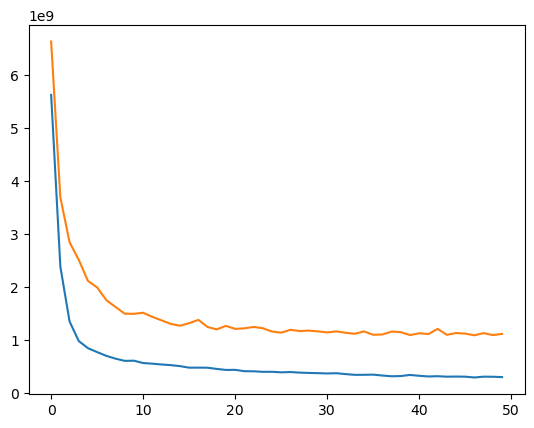

In [20]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)

In [23]:
torch.save(
    model.state_dict(),
    os.path.join(os.getenv("WEIGHTS"), "Final_Model.pth"),
)
print(f"Model saved")

Model saved
